# Logistic Regression On Email Spam Detection

First Import Whats Necessary:

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown

Then Get The Data:

In [14]:
file_id = "1R74BE6m7oLVcEdzhcke_noXvmLlwg07B"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "dataset.csv", quiet=False)

df = pd.read_csv("dataset.csv")
df.head()

Downloading...
From: https://drive.google.com/uc?id=1R74BE6m7oLVcEdzhcke_noXvmLlwg07B
To: /content/dataset.csv
100%|██████████| 8.95M/8.95M [00:00<00:00, 161MB/s]


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


Then Clean The Data:

In [15]:
# clean the text
def clean_text(text):
  text = text.lower()
  text = text.replace(".","")
  text = text.replace(",","")
  text = text.replace("!","")
  text = text.replace("Subject:","")
  return text

#clean all emails
df["clean_subject"] = df['text'].apply(clean_text)


vocab_size = 1000

# build the vocab
all_words = " ".join(df["clean_subject"]).split()

# unqiue words and counts
unique, counts = np.unique(all_words, return_counts=True)
word_counts = dict(zip(unique, counts))

# sort the words by counts
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)


# word to index mapping
common_words = [word for word, count in sorted_words[:vocab_size]]
word_to_index = {word: i for i, word in enumerate(common_words)}


# text to numerical vector
def text_to_vector(text):
  text = text.split()
  vector = np.zeros(vocab_size)
  for word in text:
    if word in word_to_index:
      vector[word_to_index[word]] += 1
  return vector

X = np.array(df['clean_subject'].apply(text_to_vector).tolist())
y = np.array(df['spam'].values).reshape(-1,1)

Show The Shape Of Cleaned Data:

In [16]:
print (X.shape)
print (y.shape)
print (df['clean_subject'])

(5728, 1000)
(5728, 1)
0       subject: naturally irresistible your corporate...
1       subject: the stock trading gunslinger  fanny i...
2       subject: unbelievable new homes made easy  im ...
3       subject: 4 color printing special  request add...
4       subject: do not have money  get software cds f...
                              ...                        
5723    subject: re : research and development charges...
5724    subject: re : receipts from visit  jim   thank...
5725    subject: re : enron case study update  wow  al...
5726    subject: re : interest  david   please  call s...
5727    subject: news : aurora 5  2 update  aurora ver...
Name: clean_subject, Length: 5728, dtype: object


Split The Data Into Training and Testing Lists:

In [ ]:
def simple_train_test_split(X, y, test_ratio=0.2):
    # Get the total number of samples
    m = X.shape[0]

    # Calculate how many samples will be in the test set
    num_test = int(m * test_ratio)

    # Shuffle the indices randomly
    indices = np.random.permutation(m)

    # Select the first 'num_test' indices for the test set
    test_indices = indices[:num_test]

    # Use the remaining indices for the training set
    train_indices = indices[num_test:]

    # Return the split datasets
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = simple_train_test_split(X, y, test_ratio=0.2)

# Print the shape of the training and test sets
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (4583, 1000)
Test shape: (1145, 1000)


Train The Logistic Regressin Model and Show Training Loss Over Epochs:

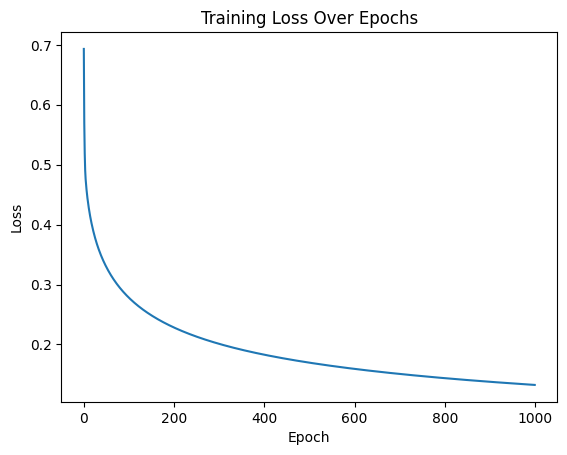

In [17]:
def train(X, y, learning_rate=0.01, epochs=1000):
    # Get number of training samples (m) and features (n)
    m = X.shape[0]
    n = X.shape[1]

    # Initialize weights (theta) to zeros and bias to 0
    theta = np.zeros((n, 1))
    bias = 0

    # List to store loss values over epochs
    loss_list = []

    for epoch in range(epochs):
        # Compute the linear combination of inputs and weights
        linear = np.dot(X, theta) + bias

        # Clip values to avoid overflow issues with exponential function
        linear_clipped = np.clip(linear, -500, 500)

        # Apply sigmoid function for probability predictions
        y_pred = 1 / (1 + np.exp(-linear_clipped))

        # Compute the binary cross-entropy loss
        loss_val = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
        loss_list.append(loss_val)

        # Update weights and bias using gradient descent
        theta -= learning_rate * (1/m) * np.dot(X.T, (y_pred - y))
        bias -= learning_rate * (1/m) * np.sum(y_pred - y)

    # Return final weights, bias, and loss values
    return theta, bias, loss_list

# Train the model
theta, bias, losses = train(X_train, y_train)

# Plot training loss over epochs
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()


Method To Predict If Spam or Not:

In [18]:
def predict(X, theta, bias):
    # Compute the linear combination of inputs and weights
    linear = np.dot(X, theta) + bias

    # Clip values to prevent overflow in the exponential function
    linear_clipped = np.clip(linear, -500, 500)

    # Apply the sigmoid function to get probabilities
    y_pred = 1 / (1 + np.exp(-linear_clipped))

    # Convert probabilities to binary class labels (0 or 1)
    return np.where(y_pred > 0.5, 1, 0)

# Generate predictions for training and test sets
p_train = predict(X_train, theta, bias)
p_test = predict(X_test, theta, bias)

Simple Method For Basline Prediction:

In [19]:
def baseline_predict(y_train, X):
    # Determine the most common class (majority class) in the training labels
    majority_class = 1 if np.mean(y_train) >= 0.5 else 0

    # Create an array where all predictions are the majority class
    return np.full((X.shape[0], 1), majority_class)

# Generate baseline predictions for training and test sets
baseline_p_train = baseline_predict(y_train, X_train)
baseline_p_test = baseline_predict(y_train, X_test)

Calculating F1 Score for Model and Baseline Performance:

In [20]:
def f1_score(y_true, y_pred):
    # Count true positives (correctly predicted as 1)
    tp = np.sum((y_true == 1) & (y_pred == 1))

    # Count true negatives (correctly predicted as 0)
    tn = np.sum((y_true == 0) & (y_pred == 0))

    # Count false positives (wrongly predicted as 1)
    fp = np.sum((y_true == 0) & (y_pred == 1))

    # Count false negatives (missed actual positives)
    fn = np.sum((y_true == 1) & (y_pred == 0))

    # Avoid division errors by adding a small number (1e-8)

    # Precision = True Positives / (True Positives + False Positives)
    precision = tp / (tp + fp + 1e-8)

    # Recall = True Positives / (True Positives + False Negatives)
    recall = tp / (tp + fn + 1e-8)

    # F1 Score = Harmonic mean of precision and recall
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    confusion_matrix = np.array([[tp, fp], [fn, tn]])

    return f1, precision, recall, confusion_matrix

# Compute F1 score for the model's predictions
f1_train, precision_train, recall_train, cm_train = f1_score(y_train, p_train)
f1_test, precision_test, recall_test, cm_test = f1_score(y_test, p_test)

print("Training Precision Score:", precision_train)
print("Training Recall Score:", recall_train)
print(f"Training F1 Score: {f1_train}")
print("Training Confusion Matrix:")
print(cm_train)
print()
print("Test Precision Score:", precision_test)
print("Test Recall Score:", recall_test)
print(f"Test F1 Score: {f1_test}")
print("Test Confusion Matrix:")
print(cm_test)

# Compute F1 scores for the baseline model (always predicting the majority class)
baseline_f1_train = f1_score(y_train, baseline_p_train)[0]
baseline_f1_test = f1_score(y_test, baseline_p_test)[0]

print("Baseline Training F1 Score:", baseline_f1_train)
print("Baseline Test F1 Score:", baseline_f1_test)

Training Precision Score: 0.9658767772420297
Training Recall Score: 0.9081996434856667
Training F1 Score: 0.9361506610503388
Training Confusion Matrix:
[[1019   36]
 [ 103 3425]]

Test Precision Score: 0.9434782608285444
Test Recall Score: 0.882113821102353
Test F1 Score: 0.9117647008496927
Test Confusion Matrix:
[[217  13]
 [ 29 886]]
Baseline Training F1 Score: 0.0
Baseline Test F1 Score: 0.0


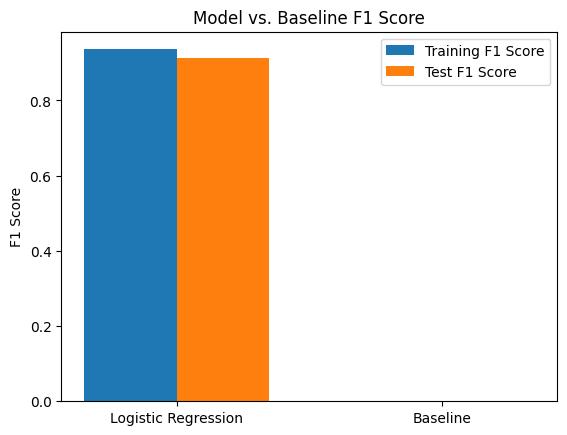

In [21]:
models = ["Logistic Regression", "Baseline"]

x_positions = np.arange(len(models))
bar_width = 0.35

plt.figure()
plt.bar(x_positions - bar_width/2, [f1_train, baseline_f1_train], .35, label="Training F1 Score")
plt.bar(x_positions + bar_width/2, [f1_test, baseline_f1_test], .35, label="Test F1 Score")
plt.xticks(x_positions, models)
plt.ylabel("F1 Score")
plt.title("Model vs. Baseline F1 Score")
plt.legend()
plt.show()

Hyperparameter Tuning – Effect of Learning Rate on Loss and F1 Score:

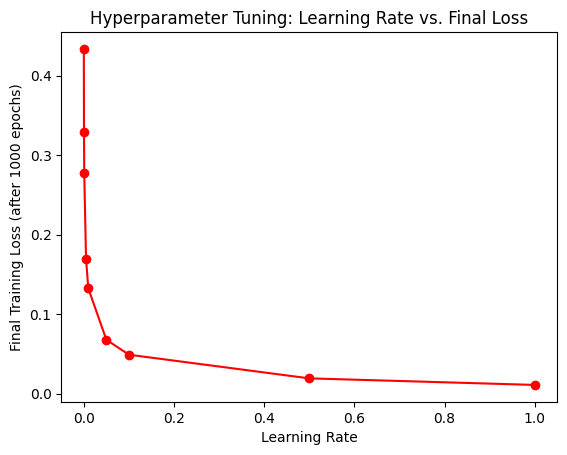

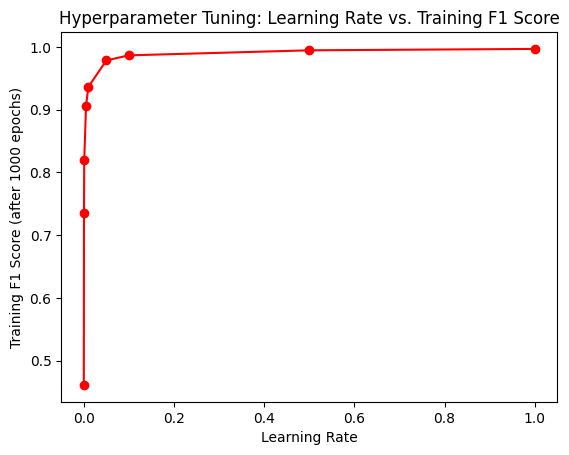

In [22]:
# Test different learning rates to see their impact on loss and model performance
learning_rates = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

final_losses = []  # Store final loss values for each learning rate
final_f1_scores = []  # Store F1 scores for each learning rate

# Train the model with different learning rates
for learning_rate in learning_rates:
    theta_temp, bias_temp, losses_temp = train(X_train, y_train, learning_rate=learning_rate, epochs=1000)

    # Get the last recorded loss value
    final_loss = losses_temp[-1]
    final_losses.append(final_loss)

    # Get the F1 score for this model
    p_temp = predict(X_train, theta_temp, bias_temp)
    f1_temp = f1_score(y_train, p_temp)
    final_f1_scores.append(f1_temp[0])

# Plot Learning Rate vs. Final Training Loss
plt.figure()
plt.plot(learning_rates, final_losses, marker="o", color="red")
plt.xlabel("Learning Rate")
plt.ylabel("Final Training Loss (after 1000 epochs)")
plt.title("Hyperparameter Tuning: Learning Rate vs. Final Loss")
plt.show()

# Plot Learning Rate vs. Training F1 Score
plt.figure()
plt.plot(learning_rates, final_f1_scores, marker="o", color="red")
plt.xlabel("Learning Rate")
plt.ylabel("Training F1 Score (after 1000 epochs)")
plt.title("Hyperparameter Tuning: Learning Rate vs. Training F1 Score")
plt.show()